# ワイブル分布に従う寿命試験のシミュレーション

　製品・部品に対する寿命試験において、破壊モードの理論や同類の製品での過去試験データから、破損確率がワイブル分布に従うという前提をおいて評価する場合が多くある。ワイブル分布の概要や確率分布の形は、[wikipedia](https://ja.wikipedia.org/wiki/%E3%83%AF%E3%82%A4%E3%83%96%E3%83%AB%E5%88%86%E5%B8%83)などを参照のこと。
 　
  一般には、寿命試験ではワイブルプロット上に試験データをプロットし、その線形近似から10%破損時間(L10)を算出し寿命の基準とすることが多い。このL10時間は、その時間までに破損する確率が10%であることを意味している。(用途によっては10%よりも低い確率での破損時間を基準とすることもある)。ただし、この手法ではL10を点推定しているのみであり、その信頼性については議論ができない。
  
　本シミュレーションプログラムは、疑似乱数により発生させたデータを基にN個の試験データに対し、ワイブルプロットの作成およびベイズ推定によるL10の確信区間の算出を行う。ベイズ推定にはPytorchをバックエンドにした確率的プログラミング言語)であるPyroを用いる。
  

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from modules import weibull_test #自作モジュール
from modules import weibull_bayes #自作モジュール
%matplotlib inline
sns.set(style='whitegrid')


## ワイブルプロットの作成

　以下では、N数を変え、ワイブルプロットを作成している。N数が増えるごとに理論値に近づいていく傾向がわかる(運がいい場合にN数が少なくても理論値に近い値をとることはある)。
 なお、今回生成するワイブル分布において、係数の真値は形状パラメータ$\mu$を1.3, 尺度パラメータ$\eta$を100としている。

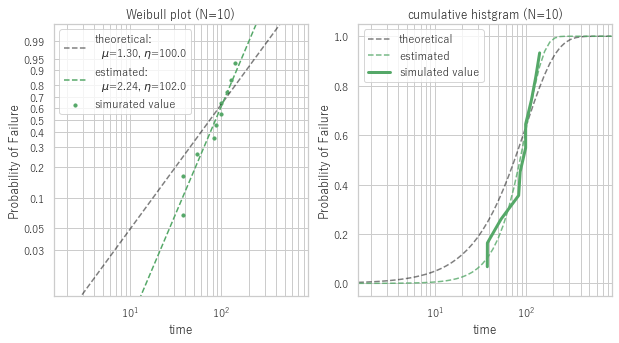

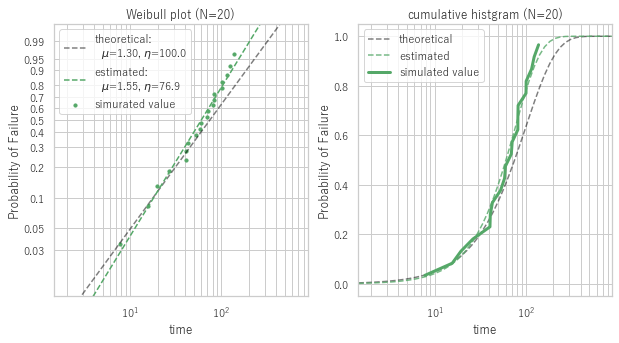

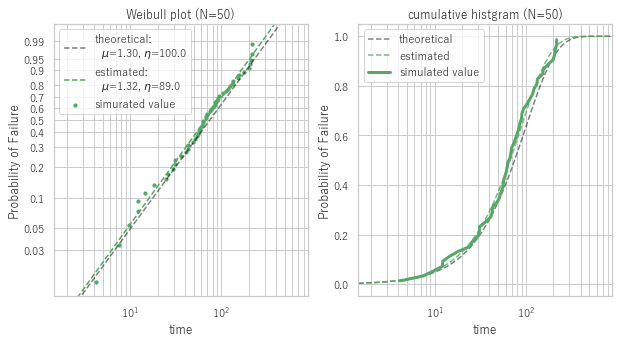

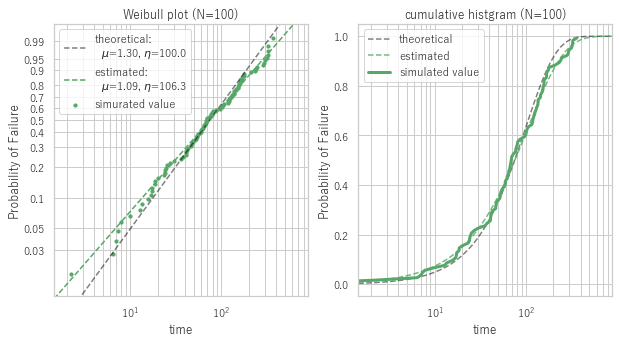

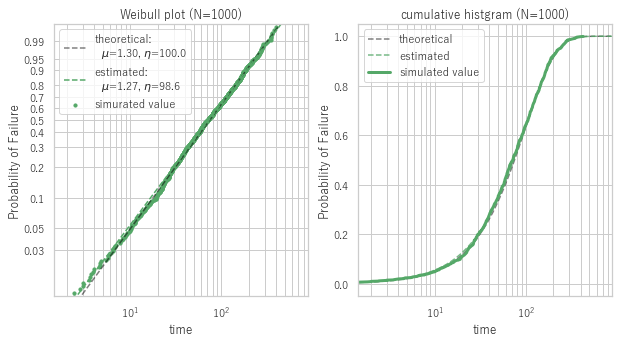

In [2]:
num_list=[10,20,50,100,1000]
for num in num_list:
    m = weibull_test.WeibullTest(num=num, weibull_mu=1.3, weibull_eta=100)
    fig, axes = m.make_plot(plot_theoritical=True)
plt.show()

## ベイズ推定

以降では、N=10の場合についてベイズ推定を行い、90%確信区間および、L10の事後分布を算出する。

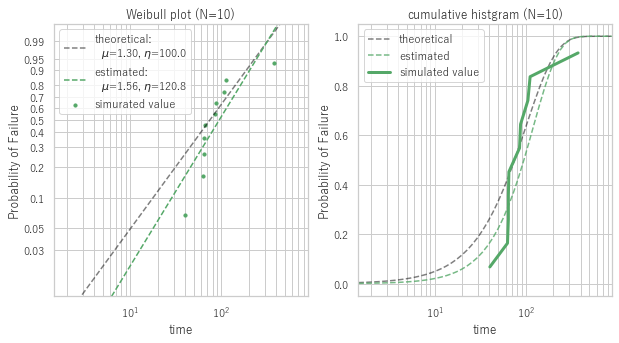

In [3]:
wb = weibull_bayes.Weibull_bayes(num = 10, weibull_mu=1.3, weibull_eta=100)

fig, axes = wb.test.make_plot(plot_theoritical=True)


In [4]:
samples=wb.mcmc(loop_num=10000)

Sample: 100%|█████████████████████████████████████| 10500/10500 [02:23, 73.00it/s, step size=5.37e-01, acc. prob=0.892]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.34      0.30      1.33      0.86      1.82   4242.87      1.00
    eta[0]    127.26     36.73    122.36     72.44    181.75   2488.15      1.00

Number of divergences: 14


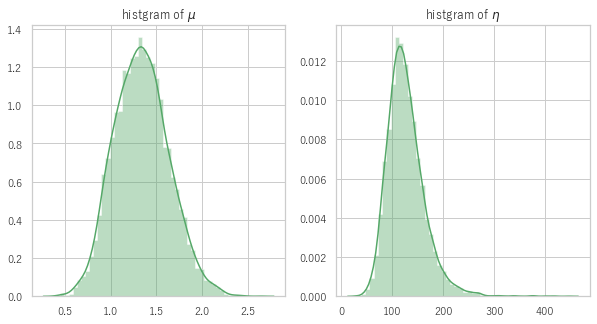

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(samples['mu'], ax = axes[0], color='g', hist_kws={'histtype':'stepfilled'})
sns.distplot(samples['eta'], ax = axes[1], color='g', hist_kws={'histtype':'stepfilled'})
axes[0].set_title(r'histgram of $\mu$')
axes[1].set_title(r'histgram of $\eta$')

plt.show()

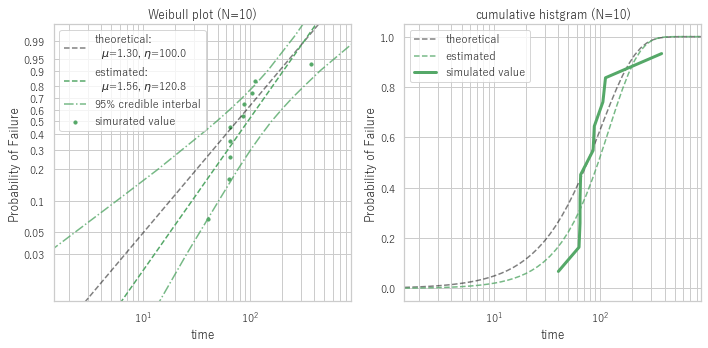

In [6]:
fig, axes = wb.test.make_plot(plot_theoritical=True)
freq=0.95
num = len(wb.failure_prob_samples[1][0])

y=wb.test.convert_unreliability_to_y(wb.failure_prob_samples[0])
sorted_fp_samples=np.sort(wb.failure_prob_samples[1], axis=1)

x_low=sorted_fp_samples[:,int(num*(1-freq)/2)]
x_high=sorted_fp_samples[:,int(num*(freq+(1-freq)/2))]

axes[0].plot(x_low,y, label='{0:.0f}% credible interbal'.format(freq*100), color='g', linestyle="-.",alpha=0.8)
axes[0].plot(x_high,y, color='g', linestyle="-.",alpha=0.8)
axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()
#plt.savefig(fname='test_weibull.png',format='png')

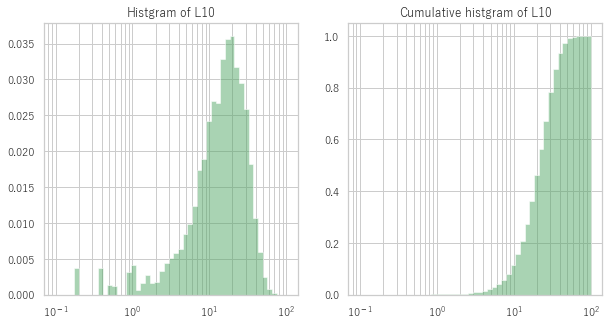

Average of L10: 23.9
90% credible interbal: 7.5, 45.0


In [7]:
freq=0.1
lifetime=wb.calc_freq_sample(freq)
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10,5))
x_bins=np.logspace(np.floor(np.log10(lifetime.min())), np.ceil(np.log10(lifetime.max())))
axes[0].hist(lifetime, bins = x_bins, histtype='stepfilled',
        density = True, alpha=0.5, color='g')
axes[1].hist(lifetime, bins = x_bins, histtype='stepfilled',
        cumulative = True, density = True, alpha=0.5, color='g')


axes[0].set_xscale('log')
axes[0].set_title('Histgram of L{0:.0f}'.format(freq*100))
axes[1].set_xscale('log')
axes[1].set_title('Cumulative histgram of L{0:.0f}'.format(freq*100))
axes[0].grid(True,which='both',axis='x')
axes[1].grid(True,which='both',axis='x')

plt.show()

print('Average of L10: {0:.1f}'.format(np.average(lifetime)))
print('90% credible interbal: {0:.1f}, {1:.1f}'.format(*np.percentile(lifetime,[5,95])))

## まとめ
　以上のように、ベイズ推定によりL10の平均値及び90%信頼区間を算出した。試験精度がどの程度必要になるかは、試験コストやその部品の重要度によっても変わってくるが、この手法を用いることで区間推定が行え、判断の根拠とすることができる。

## Appendix
　同様の手法でN=50の場合を以下に記載する。

Sample: 100%|█████████████████████████████████████| 10500/10500 [01:49, 95.49it/s, step size=9.08e-01, acc. prob=0.909]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.41      0.16      1.41      1.14      1.67   6388.68      1.00
    eta[0]    103.38     11.02    102.92     85.02    120.97   4929.70      1.00

Number of divergences: 0


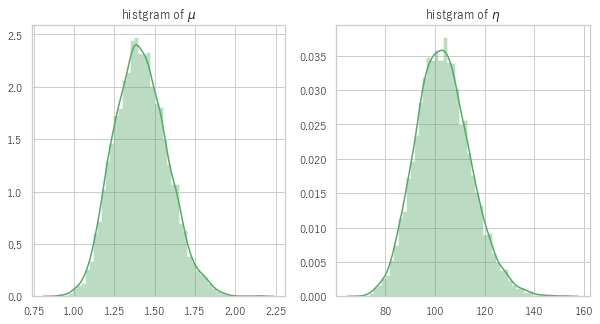

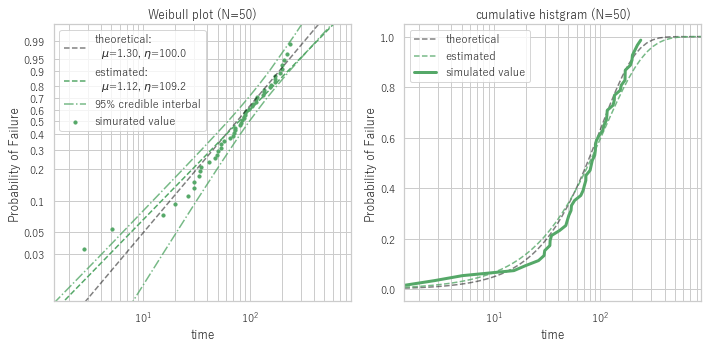

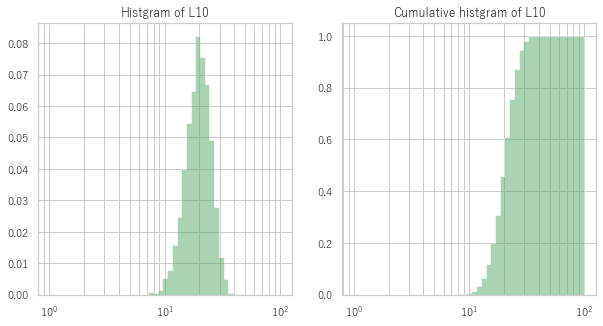

Average of L10: 21.1
90% credible interbal: 13.4, 29.6


In [8]:
wb = weibull_bayes.Weibull_bayes(num=50, weibull_mu=1.3, weibull_eta=100)
samples=wb.mcmc(loop_num=10000)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(samples['mu'], ax = axes[0], color='g', hist_kws={'histtype':'stepfilled'})
sns.distplot(samples['eta'], ax = axes[1], color='g', hist_kws={'histtype':'stepfilled'})
axes[0].set_title(r'histgram of $\mu$')
axes[1].set_title(r'histgram of $\eta$')

plt.show()

fig, axes = wb.test.make_plot(plot_theoritical=True)
freq=0.95
num = len(wb.failure_prob_samples[1][0])

y=wb.test.convert_unreliability_to_y(wb.failure_prob_samples[0])
sorted_fp_samples=np.sort(wb.failure_prob_samples[1], axis=1)

x_low=sorted_fp_samples[:,int(num*(1-freq)/2)]
x_high=sorted_fp_samples[:,int(num*(freq+(1-freq)/2))]

axes[0].plot(x_low,y, label='{0:.0f}% credible interbal'.format(freq*100), color='g', linestyle="-.",alpha=0.8)
axes[0].plot(x_high,y, color='g', linestyle="-.",alpha=0.8)
axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()
#plt.savefig(fname='test_weibull.png',format='png')

freq=0.1
lifetime=wb.calc_freq_sample(freq)
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10,5))
x_bins=np.logspace(np.floor(np.log10(lifetime.min())), np.ceil(np.log10(lifetime.max())))
axes[0].hist(lifetime, bins = x_bins, histtype='stepfilled',
        density = True, alpha=0.5, color='g')
axes[1].hist(lifetime, bins = x_bins, histtype='stepfilled',
        cumulative = True, density = True, alpha=0.5, color='g')


axes[0].set_xscale('log')
axes[0].set_title('Histgram of L{0:.0f}'.format(freq*100))
axes[1].set_xscale('log')
axes[1].set_title('Cumulative histgram of L{0:.0f}'.format(freq*100))
axes[0].grid(True,which='both',axis='x')
axes[1].grid(True,which='both',axis='x')

plt.show()

print('Average of L10: {0:.1f}'.format(np.average(lifetime)))
print('90% credible interbal: {0:.1f}, {1:.1f}'.format(*np.percentile(lifetime,[5,95])))